In [2]:
library(Seurat)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)

# co-expression network analysis packages:
library(WGCNA)
library(scWGCNA)

library(harmony)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# network analysis & visualization package:
library(igraph)


# gene enrichment packages
library(enrichR)
library(GeneOverlap)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

library(reshape2)

library(scales)

# set random seed for reproducibility
set.seed(12345)


Attaching SeuratObject

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor


Loading required package: Rcpp


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:p

# first resetup seurat object using seurat v4

In [49]:
MPOA.integrated <-readRDS(file = "/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Neurons/MPOA.integrated.rds")
new.ident <- c("Mix1","Vgat1","Vglu1","Vgat2","Vgat3","Vgat4","Mix2","Vglu2","Vgat5","Vglu3","Vglu4","Vgat6","Vgat7","Vgat8","Vglu5","Vglu6","Vgat9","Vgat10","Vgat11","Vglu7","Vgat12","Vgat13","Vgat14","Vgat15","Vglu8","Vglu9","Vgat16","Vglu10","Vgat17","Vgat18","Vgat19","Vglu11","Vglu12","Ambiguous1","Mix3","Vgat20")
names(x = new.ident) <- levels(x =MPOA.integrated)
MPOA.integrated<- RenameIdents(object =MPOA.integrated, new.ident)

In [50]:
MPOA.integrated@meta.data$celltype<-Idents(MPOA.integrated)

In [51]:
#if you like to subset data
Celltype<-c("Vgat1","Vgat2","Vgat3","Vgat4","Vgat5","Vgat6","Vgat7","Vgat8","Vgat9","Vgat10","Vgat11","Vgat12","Vgat13","Vgat14","Vgat15","Vgat16","Vgat17","Vgat18","Vgat19","Vgat20")
subsetcell<-rownames(MPOA.integrated@meta.data[(MPOA.integrated@meta.data$celltype %in% Celltype) & (MPOA.integrated@meta.data$stim %in% c("AF")),])

In [52]:
#if you like to subset data
MPOA.integrated<-subset(MPOA.integrated,cells=subsetcell)

In [56]:
seurat_obj<-MPOA.integrated

In [57]:
Celltype<-numeric()
for(i in 1:dim(seurat_obj@meta.data)[1]){
    if(seurat_obj@meta.data$celltype[i] %in% c("Vgat2","Vgat4","Vgat16")){
        Celltype[i]<-"VgatEsr1_p"
    }else{Celltype[i]<-"VgatEsr1_n"}
}
seurat_obj@meta.data$Celltype<-Celltype

In [58]:
seurat_obj<-FindVariableFeatures(seurat_obj,nfeatures = 4000)

In [59]:
seurat_obj <- SetupForWGCNA(
  seurat_obj,
  gene_select = "variable", # the gene selection approach
  fraction = 0.05, # fraction of cells that a gene needs to be expressed in order to be included
  wgcna_name = "tutorial" # the name of the scWGCNA experiment
)

In [60]:
# construct metacells  in each group
seurat_obj <- MetacellsByGroups(
  seurat_obj = seurat_obj,
  group.by = c("celltype","Celltype"), # specify the columns in seurat_obj@meta.data to group by c("celltype","stim")
  k = 10, # nearest-neighbors parameter
  ident.group = 'celltype' # set the Idents of the metacell seurat object
)

# normalize metacell expression matrix:
seurat_obj <- NormalizeMetacells(seurat_obj)

 [1] "Vgat1#VgatEsr1_n"  "Vgat10#VgatEsr1_n" "Vgat11#VgatEsr1_n"
 [4] "Vgat12#VgatEsr1_n" "Vgat13#VgatEsr1_n" "Vgat14#VgatEsr1_n"
 [7] "Vgat16#VgatEsr1_p" "Vgat17#VgatEsr1_n" "Vgat18#VgatEsr1_n"
[10] "Vgat2#VgatEsr1_p"  "Vgat3#VgatEsr1_n"  "Vgat4#VgatEsr1_p" 
[13] "Vgat5#VgatEsr1_n"  "Vgat6#VgatEsr1_n"  "Vgat7#VgatEsr1_n" 
[16] "Vgat8#VgatEsr1_n"  "Vgat9#VgatEsr1_n" 
[[1]]
    celltype     Celltype 
     "Vgat1" "VgatEsr1_n" 

[[2]]
    celltype     Celltype 
    "Vgat10" "VgatEsr1_n" 

[[3]]
    celltype     Celltype 
    "Vgat11" "VgatEsr1_n" 

[[4]]
    celltype     Celltype 
    "Vgat12" "VgatEsr1_n" 

[[5]]
    celltype     Celltype 
    "Vgat13" "VgatEsr1_n" 

[[6]]
    celltype     Celltype 
    "Vgat14" "VgatEsr1_n" 

[[7]]
    celltype     Celltype 
    "Vgat16" "VgatEsr1_p" 

[[8]]
    celltype     Celltype 
    "Vgat17" "VgatEsr1_n" 

[[9]]
    celltype     Celltype 
    "Vgat18" "VgatEsr1_n" 

[[10]]
    celltype     Celltype 
     "Vgat2" "VgatEsr1_p" 

[[11]]
    celltype

Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 0.625
Median shared cells bin-bin: 0



[1] "here"
    celltype     Celltype 
     "Vgat1" "VgatEsr1_n" 
[1] "celltype" "Celltype"
[1] 20345    55


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 1.82857142857143
Median shared cells bin-bin: 0

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
“On average, more than 10% of cells are shared between paired bins.”


[1] "here"
    celltype     Celltype 
    "Vgat10" "VgatEsr1_n" 
[1] "celltype" "Celltype"
[1] 20345    58


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 1.60818713450292
Median shared cells bin-bin: 0

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
“On average, more than 10% of cells are shared between paired bins.”


[1] "here"
    celltype     Celltype 
    "Vgat11" "VgatEsr1_n" 
[1] "celltype" "Celltype"
[1] 20345    36


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 2.68888888888889
Median shared cells bin-bin: 1

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
“On average, more than 10% of cells are shared between paired bins.”


[1] "here"
    celltype     Celltype 
    "Vgat12" "VgatEsr1_n" 
[1] "celltype" "Celltype"
[1] 20345    45


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 2.45263157894737
Median shared cells bin-bin: 1

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
“On average, more than 10% of cells are shared between paired bins.”


[1] "here"
    celltype     Celltype 
    "Vgat13" "VgatEsr1_n" 
[1] "celltype" "Celltype"
[1] 20345    55


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 1.71
Median shared cells bin-bin: 0

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
“On average, more than 10% of cells are shared between paired bins.”


[1] "here"
    celltype     Celltype 
    "Vgat14" "VgatEsr1_n" 
[1] "celltype" "Celltype"
[1] 20345    49


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 1.94771241830065
Median shared cells bin-bin: 0

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
“On average, more than 10% of cells are shared between paired bins.”


[1] "here"
    celltype     Celltype 
    "Vgat16" "VgatEsr1_p" 
[1] "celltype" "Celltype"
[1] 20345    28


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 3.62121212121212
Median shared cells bin-bin: 3.5

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
“On average, more than 10% of cells are shared between paired bins.”


[1] "here"
    celltype     Celltype 
    "Vgat17" "VgatEsr1_n" 
[1] "celltype" "Celltype"
[1] 20345    21


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 4.4
Median shared cells bin-bin: 4.5

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
“On average, more than 10% of cells are shared between paired bins.”


[1] "here"
    celltype     Celltype 
    "Vgat18" "VgatEsr1_n" 
[1] "celltype" "Celltype"
[1] 20345    83


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 1.12380952380952
Median shared cells bin-bin: 0

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
“On average, more than 10% of cells are shared between paired bins.”


[1] "here"
    celltype     Celltype 
     "Vgat2" "VgatEsr1_p" 
[1] "celltype" "Celltype"
[1] 20345   114


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 0.910014513788099
Median shared cells bin-bin: 0



[1] "here"
    celltype     Celltype 
     "Vgat3" "VgatEsr1_n" 
[1] "celltype" "Celltype"
[1] 20345   125


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 0.837296037296037
Median shared cells bin-bin: 0



[1] "here"
    celltype     Celltype 
     "Vgat4" "VgatEsr1_p" 
[1] "celltype" "Celltype"
[1] 20345    54


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 1.88235294117647
Median shared cells bin-bin: 0

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
“On average, more than 10% of cells are shared between paired bins.”


[1] "here"
    celltype     Celltype 
     "Vgat5" "VgatEsr1_n" 
[1] "celltype" "Celltype"
[1] 20345    97


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 1.07152496626181
Median shared cells bin-bin: 0

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
“On average, more than 10% of cells are shared between paired bins.”


[1] "here"
    celltype     Celltype 
     "Vgat6" "VgatEsr1_n" 
[1] "celltype" "Celltype"
[1] 20345   105


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 0.9055330634278
Median shared cells bin-bin: 0



[1] "here"
    celltype     Celltype 
     "Vgat7" "VgatEsr1_n" 
[1] "celltype" "Celltype"
[1] 20345    60


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 1.54710144927536
Median shared cells bin-bin: 0

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
“On average, more than 10% of cells are shared between paired bins.”


[1] "here"
    celltype     Celltype 
     "Vgat8" "VgatEsr1_n" 
[1] "celltype" "Celltype"
[1] 20345    35


Overlap QC metrics:
Cells per bin: 10
Maximum shared cells bin-bin: 8
Mean shared cells bin-bin: 2.89393939393939
Median shared cells bin-bin: 2

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
“On average, more than 10% of cells are shared between paired bins.”


[1] "here"
    celltype     Celltype 
     "Vgat9" "VgatEsr1_n" 
[1] "celltype" "Celltype"


In [61]:
metacell_obj <- GetMetacellObject(seurat_obj)

In [62]:
seurat_obj <- SetDatExpr(
  seurat_obj,
  group.by='Celltype', #using stim since only one group the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
  group_name = "VgatEsr1_p", # the name of the group of interest in the group.by column
  use_metacells=TRUE,
  slot = 'data'
)

[1] "n_genes:"
[1] 4000
[1] "Sst"   "Penk"  "Avp"   "Meis2" "Vgf"   "Nts"  
[1] 496   5
[1] 120   5
[1] 120   5
[1] "cells:"
[1] "Vgat16#VgatEsr1_p_1" "Vgat16#VgatEsr1_p_2" "Vgat16#VgatEsr1_p_3"
[4] "Vgat16#VgatEsr1_p_4" "Vgat16#VgatEsr1_p_5" "Vgat16#VgatEsr1_p_6"
[1] 120
  ..Excluding 127 genes from the calculation due to too many missing samples or zero variance.
[1]  120 3873


pickSoftThreshold: will use block size 3873.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 3873 of 3873


Warning message:
“executing %dopar% sequentially: no parallel backend registered”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.  max.k.
1      1   0.0702   8.87          0.990 1950.000  1.95e+03 2050.00
2      2   0.2140  -8.05          0.916 1020.000  1.01e+03 1160.00
3      3   0.7300 -10.60          0.971  549.000  5.41e+02  693.00
4      4   0.7080  -7.54          0.947  306.000  2.98e+02  434.00
5      5   0.6640  -5.77          0.938  176.000  1.69e+02  285.00
6      6   0.6980  -4.76          0.947  104.000  9.85e+01  194.00
7      7   0.7380  -4.22          0.967   62.900  5.88e+01  136.00
8      8   0.7840  -3.75          0.972   39.100  3.59e+01   97.70
9      9   0.8220  -3.51          0.982   24.900  2.23e+01   71.90
10    10   0.8450  -3.28          0.976   16.200  1.42e+01   53.90
11    12   0.8950  -2.86          0.992    7.330  6.01e+00   31.90
12    14   0.8990  -2.69          0.985    3.600  2.69e+00   20.60
13    16   0.9000  -2.46          0.975    1.910  1.26e+00   14.00
14    18   0.9220  -2.15          0.966    1.090  6.20e-01    

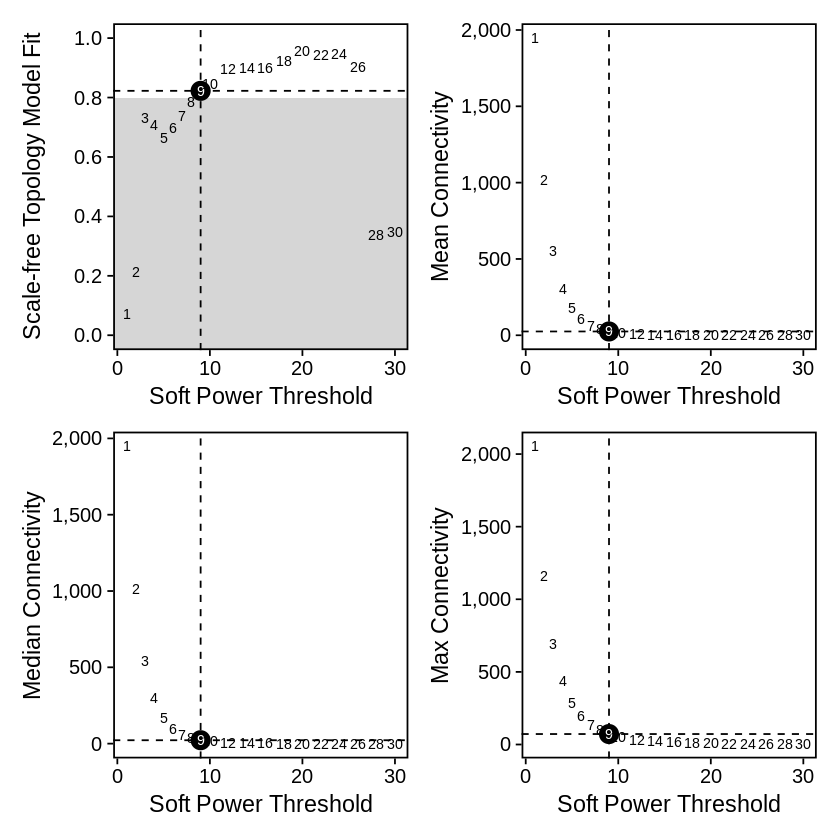

In [63]:
# Test different soft powers:
seurat_obj <- TestSoftPowers(
  seurat_obj,
  setDatExpr = FALSE, # set this to FALSE since we did this above
)

# plot the results:
plot_list <- PlotSoftPowers(seurat_obj)

# assemble with patchwork
wrap_plots(plot_list, ncol=2)

In [64]:
power_table <- GetPowerTable(seurat_obj)
head(power_table)

,Power,SFT.R.sq,slope,truncated.R.sq,mean.k.,median.k.,max.k.
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.07018512,8.865530,0.9896182,1946.8561,1947.03910,2052.1972
2,2,0.21429712,-8.054077,0.9158701,1016.1548,1010.36144,1159.4894
3,3,0.72984412,-10.637855,0.9709825,548.8633,540.62837,692.7328
4,4,0.70791158,-7.544662,0.9472362,306.0280,298.06439,434.3918
5,5,0.66392150,-5.768220,0.9380968,175.7673,168.96347,285.4177
6,6,0.69766603,-4.755309,0.9469904,103.8027,98.49433,194.1012


In [65]:
# construct co-expression network:
seurat_obj <- ConstructNetwork(
  seurat_obj, soft_power=9,
  setDatExpr=FALSE
)

 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


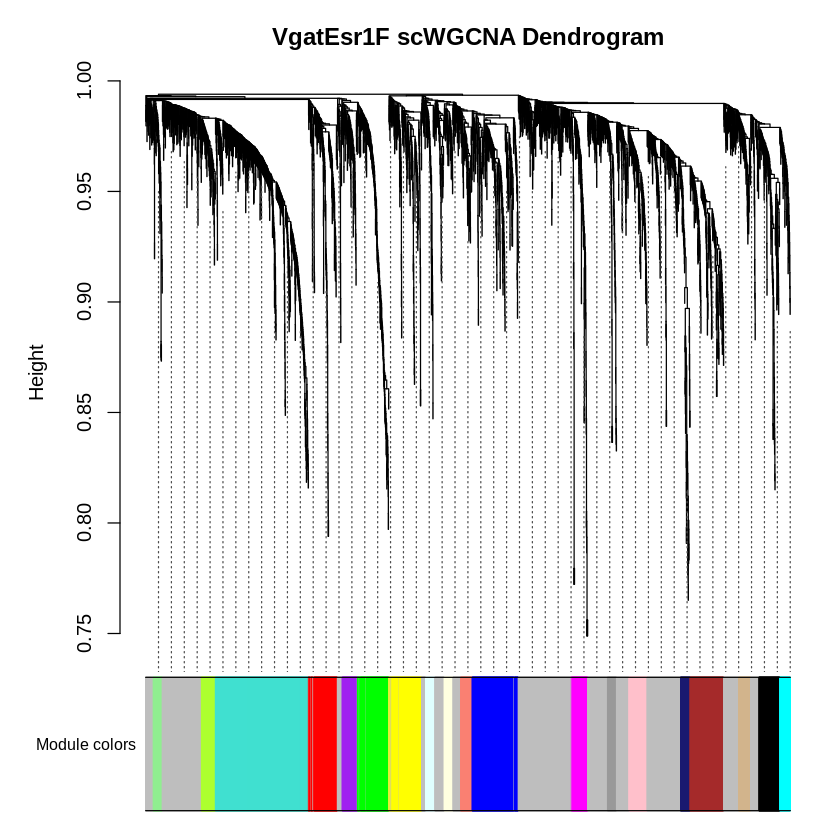

In [66]:
PlotDendrogram(seurat_obj, main='VgatEsr1F scWGCNA Dendrogram')

In [67]:
# expression matrix for all the WGCNA genes:
seurat_obj <- Seurat::ScaleData(
 seurat_obj,
 features = GetWGCNAGenes(seurat_obj)
)

# compute all MEs in the full single-cell dataset
seurat_obj <- ModuleEigengenes(
 seurat_obj)
#, group.by.vars="stim") #in case not using batch correction

Centering and scaling data matrix



[1] "turquoise"


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcaturquoise_”
pcaturquoise_ 1 
Positive:  6330403K07Rik, Esr1, Gda, Rpl36a, Fam46a, Pkm, Pnmal1, G3bp2, Prkce, Hpcal4 
	   Aes, Atp6v1b2, Arhgef9, Tmsb4x, Hspa4, Fgfr1, Dcaf12l1, Prkar2a, 1500009L16Rik, Plcb4 
	   Plekhb1, 1700037H04Rik, Hmgcs1, Hmgn2, AW551984, Timm8b, Ndrg3, Ptms, Enah, Gng4 
Negative:  Vstm2l, Grm5, Cck, Cd27, Tacr3, Man1a, Zeb2, Ncam1, Ryr2, Avp 
	   Lhx8, Gm45352, Six3, Chrm3, Tac1, Dsel, Nup210, Npffr1, Caprin2, Gfra2 
	   Kcnab3, Shh, Dffb, Crispld2, Adgrf5, Grem1, Ap5z1, Epha3, B230317F23Rik, Ephb6 
pcaturquoise_ 2 
Positive:  Tmsb4x, Rpl36a, Six3, Atp6v1b2, Pkm, Aes, Ptms, Got1, Ndrg3, G3bp2 
	   Prkar2a, Arx, Pcbp1, B630019K06Rik, Csrnp3, Habp4, Got2, Uqcrfs1, Nars, Vapb 
	   Zbtb4, Eif1ax, Timm8b, O

[1] "grey"


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagrey_”
pcagrey_ 1 
Positive:  Atp1b1, Slc24a5, Pam, Lgr4, AC160336.1, Slitrk4, Spock3, Cntn1, Gas6, 4930447C04Rik 
	   Fam3c, Grik2, Manea, Grm1, Gm21887, Npy, Kdelr2, Fstl5, Stxbp3, Adgrg1 
	   Asic4, Kcnc2, Pcdhb22, Zdhhc22, Ntrk3, Abhd2, Gpc3, AC101921.1, Arhgef1, Tmem30c 
Negative:  Ywhaz, Gabarapl1, Pnmal2, Prkar1b, Tspyl4, Prkar1a, Set, Mapt, Pja2, Snrpn 
	   2900097C17Rik, Ywhae, Map1b, Cox7c, Rab6a, Rnf11, Pfdn2, Morf4l1, Skp1a, Calm2 
	   Ywhaq, Ppp3r1, Hnrnpa1, Necap1, Eef1b2, Napb, Camk2n2, Lonrf2, Snap47, Gnaq 
pcagrey_ 2 
Positive:  Sub1, Bex2, D430019H16Rik, Pou2f2, Sox5, Mkl2, Eef1b2, Ccnb1ip1, Pcbd1, Pdcd4 
	   Gse1, Sec61b, Nos1ap, Rpl36al, Ywhaz, Rps6ka5, Pnmal2, Ncl, Alkbh5, Fam189a2 
	   4833439L19Rik, Crip2, Lonrf

[1] "pink"


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcapink to pcapink_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcapink_”
pcapink_ 1 
Positive:  Trp53i11, St8sia4, Col25a1, Sema3c, Lrrtm4, Tspan5, Frmd3, Nudt5, Ptchd4, Sorcs1 
	   Tnr, Tnfsf11, Pag1, Kit, Shisa9, Dlk1, S100a1, Strip2, Gm32585, Ano1 
	   Galntl6, Opn3, Tmem132c, Gm47204, Cntnap4, Gm10710, Serinc5, Zfp707, Sema6d, Pid1 
Negative:  Pak3, Clip3, Gnas, Prkaca, Nos1, Arfgef3, Anks1b, Golph3, Trim32, Dlx1 
	   Cep170b, Nudt4, Cplx2, Tshz1, Socs5, Ctnnbip1, Spred1, Mafa, Pdzrn4, Acat2 
	   Kcnip1, Psd3, Capns1, Bcat1, Tcerg1l, 3110035E14Rik, Actr1a, Ak1, Nts, Bbx 
pcapink_ 2 
Positive:  Nts, Chl1, Pcdh7, Nell1, Neo1, Mafa, Tmem132c, Opn3, Pcdh20, Cntnap4 
	   Sall1, Nectin3, Serinc5, Cbln2, Shisa9, Drp2, Pdzrn4, Susd4, Sorcs1, Cthrc1 
	   Gm26911, Lypd6, Wscd1, Lrrtm4, Sdk2, Sema6d, Galnt

[1] "black"


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablack to pcablack_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcablack_”
pcablack_ 1 
Positive:  Echdc2, Chrm1, Ntn1, Fam181a, Cd44, Sfrp2, Cachd1, Slc44a3, Ccdc163, Meg3 
	   Ptpn3, Acaa1b, Plin3, Nppc, Cfi, Pabpc4l, Tdrd5, St6galnac2, Cyp2d22, Pcdh19 
	   Ptger2, Il17re, Adamtsl1, Lsmem1, Car12, Whamm, Crh, Sntb1, Kremen2, Gm10642 
Negative:  Mtpn, Nrgn, Purb, Rgs4, Hpca, Pkia, Hnrnpd, Mecp2, Kcnq3, Nkd2 
	   Wasl, Fam163b, Bcl2l1, Atox1, Plekhg1, Glra1, Tpd52l1, Oat, Cluh, Gpatch4 
	   Rasgef1b, Rassf5, Glt1d1, Pdhx, Pde8b, Ptprd, Diras2, U2af1, Iqgap2, Lama2 
pcablack_ 2 
Positive:  Tacr1, Ntm, Pcdh19, Ptprd, Meg3, 9530059O14Rik, Cntn5, Spock1, Sulf2, Sfrp2 
	   Cacng3, Trhde, Ntn1, Nppc, Dkk3, Tmem108, Glra1, Kcnq3, Chrm1, Flrt3 
	   Kcnt2, Rgs6, Car10, Nrgn, Lrpprc, Ccnd2, Nkd2, Ano3, Igf1,

[1] "red"


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcared to pcared_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcared_”
pcared_ 1 
Positive:  Adam23, AL589692.1, Tpbg, Defb1, Sfi1, Gm26798, C630031E19Rik, Trpm3, Slc5a7, Gla 
	   Adam12, H2-M3, Igfbp4, G0s2, Fibcd1, S100b, Slc38a11, Htr1f, Irgm1, Tdrd12 
	   Cyp20a1, Ccbe1, Klhl14, Map2k6, Gm9748, Gsap, Mxra8, Macrod1, Atp8b5, Mettl25 
Negative:  Ndufa6, Nudt11, Nsa2, Ube2s, Shoc2, Arhgap35, Maob, Ankrd50, Csnk1d, Nsrp1 
	   Map2k7, Zswim1, Cadps, Tmem263, Tox3, Crtc1, Hebp2, Ezr, Maml3, A830010M20Rik 
	   Kcnk2, Mtus1, Fam149a, Spata13, Gtf3a, Auh, Adarb1, Zadh2, Drosha, Rsph4a 
pcared_ 2 
Positive:  Zic1, Prkca, Hspb8, Slc38a11, Fam122b, Fos, Klhl14, Nr4a2, Cpne8, Sox9 
	   Lurap1, Igfbpl1, A830010M20Rik, Haus3, D330045A20Rik, Edaradd, Ahcy, Fibcd1, Tox3, Grb14 
	   Lancl3, Auh, Mxra8, Sirt1, Tanc

[1] "cyan"


Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcacyan to pcacyan_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcacyan_”
pcacyan_ 1 
Positive:  Gpc6, Cdh6, Kcna1, Lrrtm3, Cnih3, Slc6a17, Alcam, Cadm2, Cobll1, Rtn4rl1 
	   Gm44812, Sema3e, Hcrtr2, Gm16062, Kcnf1, Oasl2, Mir670hg, Gm43848, Aanat, Gcat 
	   Prex2, Prr14, Tnfrsf19, Snx29, Timp3, Nr2f1, Igfbp3, Gm10600, 2700069I18Rik, Brs3 
Negative:  Vamp2, Gng2, Tceal9, Rplp1, Rgs10, Rab27b, Rgs2, Nol4, Dnajc27, Tmem65 
	   Wasf3, Asb4, Dab1, C1ql3, Calcr, Ppp1r14c, Cacnb4, Mtus2, Klhl4, Phf24 
	   Ipcef1, St6galnac5, Plvap, Dtna, Gm47033, Exoc8, Clmn, Pde1a, Mgat4c, Ppm1h 
pcacyan_ 2 
Positive:  Rplp1, Vamp2, Tceal9, Gng2, Dnajc27, Exoc8, Wasf3

[1] "brown"


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcabrown to pcabrown_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcabrown_”
pcabrown_ 1 
Positive:  Pcsk1n, Pcdh17, Scn2b, Gabrg1, Coro6, Ptn, Nxph1, Robo1, Fut9, Pcdhb17 
	   Casz1, Kitl, Gapdhs, Cpa6, Gabra2, Angpt1, Sgpp2, Coch, Hhat, Osbpl3 
	   Pcdh11x, Trhr, Mdga1, Pde11a, Adcyap1, Pnldc1, Pde3a, Rbks, Glra3, Alg9 
Negative:  Ywhab, Gap43, Basp1, Zwint, Ywhag, Ywhah, Atp6v1a, Dynll2, Stxbp1, Impact 
	   Nsf, Calm3, Rab6b, Ndrg4, Gad2, Flywch1, Pfn2, Vsnl1, Rcan2, Syn2 
	   Snap25, Mllt11, Syn1, Sncb, Camk2n1, Gad1, Dnajc5, Pak1, Kifap3, Sqstm1 
pcabrown_ 2 
Positive:  Vstm2a, Gabra1, Syt1, Fut9, Scn2b, Tenm2, Glra3, Nat8l, Syt4, Robo1 
	   Tenm4, Cd83, Epha4, Pcdh17, Coro6, Slc24a2, Dhcr24, Clstn2, Pcsk1n, Glra2 
	   2900055J20Rik, Lgi1, Elfn1, Ptprt, Chrm2, Kcna6, Grin2a, Gpr22, Efnb2, Robo2 

[1] "grey60"


Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey60 to pcagrey60_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagrey60_”
Warning message:
“Requested number is larger than the number of available items (54). Setting to 54.”
Warning message:
“Requested number is larger than the number of available items (54). Setting to 54.”
Warning message:
“Requested number is larger than the number of available items (54). Setting to 54.”
Warning message:
“Requested number is larger than the number of available items (54). Setting to 54.”
Warning message:
“Requested number is larger than the number of available items (54). Setting to 54.”
pcagrey60_ 1 
Positive:  Prokr2, Fam43a, Cdc14a, Zscan29, Gm1149

[1] "midnightblue"


Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcamidnightblue to pcamidnightblue_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcamidnightblue_”
Warning message:
“Requested number is larger than the number of available items (57). Setting to 57.”
Warning message:
“Requested number is larger than the number of available items (57). Setting to 57.”
Warning message:
“Requested number is larger than the number of available items (57). Setting to 57.”
Warning message:
“Requested number is larger than the number of available items (57). Setting to 57.”
Warning message:
“Requested number is larger than the number of available items (57). Setting to 57.”
pcamidnightblue_ 1 
Positive:  Gm44210, Chil1,

[1] "greenyellow"


Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagreenyellow to pcagreenyellow_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagreenyellow_”
pcagreenyellow_ 1 
Positive:  Peg3, Calm1, Map7d2, Synj1, Vat1, Scrn1, Mt3, Map2k4, Cltc, Hsph1 
	   Arhgef17, Map1a, Pcp4, Ubqln1, Sdcbp, Mapre1, Eif1a, Dync1i1, C530008M17Rik, Ppm1b 
	   Nexmif, Fdx1, Cdkl5, Bbs4, Cyhr1, Rab5c, Ncor2, Pls3, Foxk1, Smim1 
Negative:  Insig1, Fam234b, Hapln4, Lynx1, Gm29374, Cngb1, Lhfpl3, Slc1a6, Gpc5, Klc3 
	   Fdps, Tmem35a, Cryz, Cox7a1, Fosb, Aifm3, Tmem151a, Nedd9, Wdfy2, Pfkfb3 
	   Ctbp2, Epdr1, Syt17, Net1, Slco3a1, Higd1a, Atg101, A330009N23Rik, Tfe3, Pip5k1b 
pcagreenyellow_ 2 
Positive:  Syt17, Calm1, Fdx1, S

[1] "blue"


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcablue_”
pcablue_ 1 
Positive:  Nap1l5, Selenow, Marcksl1, Hap1, Ptma, Chd3, Eid1, Ppp3ca, Ar, Map1lc3a 
	   Dcaf7, Hlf, Nr3c1, Gas7, Arpc2, Anp32a, Bub3, Rab11fip4, Wasf1, Krt1 
	   Nme1, Nr2f2, Rere, Bag4, Supt6, Id4, Fam81a, Ctnna2, Ing2, Lypd1 
Negative:  Sfrp1, Slc6a1, Dnah7b, Gm32647, Pcdh10, Tatdn3, Tnfrsf21, Grik1, Gpr155, Gm10827 
	   Bach2, Ndst4, Igsf3, Mus81, Rnf128, Ptgds, Col9a2, Cox6a2, Cacna2d2, Chrna4 
	   2810049E08Rik, Gng8, 4933408B17Rik, Fzd9, Prdm12, Pcdh9, Dusp1, Rasa4, Krt25, Il1rapl1 
pcablue_ 2 
Positive:  Prlr, Pcdh10, Pgr15l, Lypd1, Hmx2, Maf, Itih5, Thsd7a, Gabrq, Tnfrsf21 
	   Ar, Cldn1, Grm8, Cd24a, Lix1, Sox4, Id4, Sccpdh, Nr2f2, Sorcs3 
	   Unc5d, Bub3, Rarb, Greb1, Il1rapl1, Gm34466, Efemp1, Socs2, Asic

[1] "magenta"


Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcamagenta to pcamagenta_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcamagenta_”
pcamagenta_ 1 
Positive:  Marcks, Prkacb, Phyhip, Cox4i1, Ndufb5, Pip4k2a, Mea1, Eri3, Ccdc85a, Rprm 
	   Auts2, Shisa6, Ublcp1, Rftn1, Plcl1, Phlda1, Spon1, Lmo1, Kctd12, Phf21b 
	   Ddhd1, Rnf144b, 2900009J06Rik, Hk2, Cacng4, Gnb4, Syndig1l, Necab2, Fbn2, Tmem160 
Negative:  Gm12027, Xaf1, D030055H07Rik, Il11ra1, Brinp3, Gm13269, Onecut3, Gm42303, Cntnap5c, Plp2 
	   Gm12216, Thbs2, Gm47950, Gm26511, Trim7, Gm26809, Fam83a, Gm31805, 6430573F11Rik, Uchl4 
	   Vwa1, Lpar6, 1700001O22Rik, A230005M16Rik, Hacd1, Creb5, Kcnd2, Dmrtb1, Mcm10, Pnp 
pcamagenta_ 2 
Positiv

[1] "yellow"


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcayellow to pcayellow_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcayellow_”
pcayellow_ 1 
Positive:  Rpsa, Slc25a4, Hsp90ab1, Bex1, Pea15a, Ctnnb1, Atp5a1, Btf3, Tub, Pnma2 
	   Clta, Rorb, Eif4b, Dgkk, Cited2, 6430548M08Rik, Sox2, Zrsr1, Rhob, Peg10 
	   Arl4a, Clvs1, Ubfd1, Nrip3, Erc2, Lamtor3, Cry2, Yeats4, Dlx6, Prdx6 
Negative:  Gm47283, Synpr, Gria3, Slitrk2, Cxcl14, Pdpn, Plk3, Ido2, Gm48393, Cenpf 
	   Wdr3, Wls, Tmem267, B3galt2, Vsig10, Rbp1, Gemin2, Grn, Gm20387, Tmem132b 
	   Nphp3, Neb, Pcsk5, Pthlh, AC160562.1, Impg2, Urb2, Tmem100, Spef2, Iapp 
pcayellow_ 2 
Positive:  Wfs1, Prok2, Grm7, Dio3, Dpy19l3, Crb1, Tmem132b, Luzp2, Fam13a, Prdx6 
	   Plcxd3, Ccne1, Gpc4, Slitrk2, Neb, Gm47283, Fam174b, Itpr1, Gulp1, Nrp2 
	   Avpr1a, Clic4, Gria3, Gemin2, Rorb, Synpr, Ahr, Gm45159, Plk3,

[1] "lightgreen"


Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcalightgreen to pcalightgreen_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcalightgreen_”
Warning message:
“Requested number is larger than the number of available items (54). Setting to 54.”
Warning message:
“Requested number is larger than the number of available items (54). Setting to 54.”
Warning message:
“Requested number is larger than the number of available items (54). Setting to 54.”
Warning message:
“Requested number is larger than the number of available items (54). Setting to 54.”
Warning message:
“Requested number is larger than the number of available items (54). Setting to 54.”
pcalightgreen_ 1 
Positive:  Npas1, Arpc1b, Lhx1, Re

[1] "purple"


Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcapurple to pcapurple_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcapurple_”
pcapurple_ 1 
Positive:  Arxes1, Fam19a1, Cacna2d3, Trh, Nt5e, Rbm41, Fan1, Tcim, Pim1, Ptgs1 
	   Dlec1, B630019A10Rik, Arsk, Rwdd3, Nnmt, Stac, Utp20, Gm42715, Entpd7, Lrrc46 
	   Col8a1, Esr2, Gca, Cited4, Gm26953, Gm43154, Rhno1, Qk, Xylt1, Itga4 
Negative:  Rnf220, Cap2, Apoc3, Prdx5, Creb1, Gtf2h1, Cmpk2, Zfp318, Fam222b, Hrk 
	   Npas2, Mir9-3hg, Nfix, Ago3, Lmo3, Ddx10, Wipi1, Bpgm, Gspt2, Vcpkmt 
	   Phpt1, Dnajc2, Rbbp8, Rnd3, Ascl1, Agps, Mkl1, Dcdc2a, Irak2, Phf7 
pcapurple_ 2 
Positive:  Nfix, Lmo3, Vcan, Trh, Cacna2d3, Tmem176b, Htr3a, Qk, Frg2f1, Pcdhb1

[1] "lightcyan"


Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcalightcyan to pcalightcyan_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcalightcyan_”
Warning message:
“Requested number is larger than the number of available items (56). Setting to 56.”
Warning message:
“Requested number is larger than the number of available items (56). Setting to 56.”
Warning message:
“Requested number is larger than the number of available items (56). Setting to 56.”
Warning message:
“Requested number is larger than the number of available items (56). Setting to 56.”
Warning message:
“Requested number is larger than the number of available items (56). Setting to 56.”
pcalightcyan_ 1 
Positive:  Hnrnpab, Dmac2, Upf1, Cd3ea

[1] "tan"


Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcatan to pcatan_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcatan_”
pcatan_ 1 
Positive:  Tmsb10, Chd3os, Gnao1, Mrfap1, Stmn1, Tubb4a, Vat1l, Ppia, Dynll1, Fth1 
	   Ptges3, Thra, Mapre2, Cfl1, Ran, Ptp4a2, 2900011O08Rik, Kif21a, Cycs, Pdxk 
	   Spryd7, Rab3a, Mdh1, Tubb2a, Ssx2ip, Pbx1, Tom1l2, Hspa12a, Tceal1, Dnajb1 
Negative:  Grem2, Pcdhb18, Pde4d, Sfxn3, Cdh11, Lrtm2, Cpne6, Kcnh1, Myc, Gm33533 
	   A230087F16Rik, Pinx1, Gm3667, Dusp6, A330102I10Rik, Rasgrp2, Dact1, Slitrk5, Rasgef1c, Ddi2 
	   Zbed4, Rora, Smim13, Phactr2, Stc1, Lrrc49, Magi1, Fabp3, Zfp30, Ubash3b 
pcatan_ 2 
Positive:  Grem2, Smim13, Rasgrp2, Sfxn3, Srgap1, Ubash3b, 

[1] "lightyellow"


Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcalightyellow to pcalightyellow_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcalightyellow_”
Warning message:
“Requested number is larger than the number of available items (53). Setting to 53.”
Warning message:
“Requested number is larger than the number of available items (53). Setting to 53.”
Warning message:
“Requested number is larger than the number of available items (53). Setting to 53.”
Warning message:
“Requested number is larger than the number of available items (53). Setting to 53.”
Warning message:
“Requested number is larger than the number of available items (53). Setting to 53.”
pcalightyellow_ 1 
Positive:  Ahi1, Celf4, Tubb5,

[1] "salmon"


Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcasalmon to pcasalmon_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcasalmon_”
pcasalmon_ 1 
Positive:  Moxd1, Gcdh, Zfp94, Edil3, Tmem132d, 1700088E04Rik, Dpp10, Tox, Syt7, 1700007K13Rik 
	   Slc16a2, Gm28884, Mak, Dlx5, Foxo6, D930020B18Rik, Zfp976, Pdk2, Dmd, Rassf3 
	   Cpne7, Ntsr1, Slit3, Tcf4, Mical2, Ptprk, Npy1r, Nkx2-1, Tesc, Nrbf2 
Negative:  Irs4, Zcchc12, Dgkb, Tmcc3, Eif1b, Wdr6, Eif4g2, Efhd2, Ptp4a1, Pde1c 
	   Pgr, Herc3, Klhdc10, Stum, Htr1b, Tmem158, Rasgrf2, Tspan7, Mettl9, Rundc3b 
	   Nek7, Prr36, 1810041L15Rik, Nap1l3, Il13ra1, Bcl11a, Stk32a, Esd, Cpne5, Cul4a 
pcasalmon_ 2 
Positive:  Eif4g2, Wdr6, Tox, Rasgrf2, Nap1l3, 

[1] "green"


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagreen to pcagreen_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagreen_”
pcagreen_ 1 
Positive:  Rps3a1, Rps19, Rpl3, Rps6, Rpl35a, Rpl9, Rps8, Rpl26, Rps23, Rps16 
	   Rpl14, Rps24, Rpl37a, Rps27, Rpl37, Rpl34, Rpl21, Rps3, Eef1a1, Rps25 
	   Rps27a, Rps14, Rps12, Rps15a, Rps18, Rpl10, Rpl19, Rpl32, Rpl41, Pfdn5 
Negative:  Rmst, Cntn4, Trpc4, Ptprz1, 9330104G04Rik, Cfap44, Dlx6os1, Tgfb3, Acad10, Kcnip4 
	   Exoc7, Amt, Cldnd1, Gm40557, Gm7967, Rassf4, Ngly1, Acot3, Eya4, Tmem26 
	   Spsb2, Ttf1, Klf12, Slc41a1, Fam90a1b, Plch2, Esf1, Afg1l, Acbd4, Rrm1 
pcagreen_ 2 
Positive:  Rps29, Rpl17, Pi16, Rpl39, Rpl23a, Plch2, Rpl31, Rps25, Rps8, Klf12 
	   Rpl37a, Rpl21, Rps24, Kcnh8, Rps15, Rpl18a, Rps26, Rpl23, Rpl37, Rpl27a 
	   Trpc4, Rpl26, Rps27, Rpl4, Rpl13, Rpl38, Rps6, Use1, Rpl14, Rpl32 
Neg

 [1] "lightcyan"    "magenta"      "turquoise"    "lightyellow"  "greenyellow" 
 [6] "blue"         "tan"          "yellow"       "green"        "midnightblue"
[11] "grey60"       "lightgreen"   "black"        "red"          "pink"        
[16] "cyan"         "grey"         "brown"        "purple"       "salmon"      


In [68]:
# harmonized module eigengenes:
hMEs <- GetMEs(seurat_obj)

# module eigengenes:
MEs <- GetMEs(seurat_obj, harmonized=FALSE)

In [69]:
# compute intramodular connectivity:
seurat_obj <- ModuleConnectivity(seurat_obj)

[1] "running signedKME:"


Warning message in bicor(datExpr, datME, , use = "p"):
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


In [70]:
# rename the modules
seurat_obj <- ResetModuleNames(
  seurat_obj,
  new_name = "Module_P50F"
)

In [71]:
# get the module assignment table:
modules <- GetModules(seurat_obj)

In [130]:
saveRDS(seurat_obj, file='scWGCNA_object_ownMPOAF_4000_10_VgatEsr1.rds')

In [28]:
#start from here

In [3]:
seurat_obj<-readRDS(file='scWGCNA_object_ownMPOAF_4000_10_VgatEsr1.rds')

In [5]:

# with UCell method
library(UCell)
seurat_obj <- ModuleExprScore(
  seurat_obj,
  n_genes = 25,
  method='UCell'
)

Selecting by kME_Module_P50F1
Selecting by kME_Module_P50F2
Selecting by kME_Module_P50F3
Selecting by kME_Module_P50F4
Selecting by kME_Module_P50F5
Selecting by kME_Module_P50F6
Selecting by kME_Module_P50F7
Selecting by kME_Module_P50F8
Selecting by kME_Module_P50F9
Selecting by kME_Module_P50F10
Selecting by kME_Module_P50F11
Selecting by kME_Module_P50F12
Selecting by kME_Module_P50F13
Selecting by kME_Module_P50F14
Selecting by kME_Module_P50F15
Selecting by kME_Module_P50F16
Selecting by kME_Module_P50F17
Selecting by kME_Module_P50F18
Selecting by kME_Module_P50F19


[1] "Module_P50F1"
[1] "Module_P50F2"
[1] "Module_P50F3"
[1] "Module_P50F4"
[1] "Module_P50F5"
[1] "Module_P50F6"
[1] "Module_P50F7"
[1] "Module_P50F8"
[1] "Module_P50F9"
[1] "Module_P50F10"
[1] "Module_P50F11"
[1] "Module_P50F12"
[1] "Module_P50F13"
[1] "Module_P50F14"
[1] "Module_P50F15"
[1] "Module_P50F16"
[1] "Module_P50F17"
[1] "Module_P50F18"
[1] "Module_P50F19"


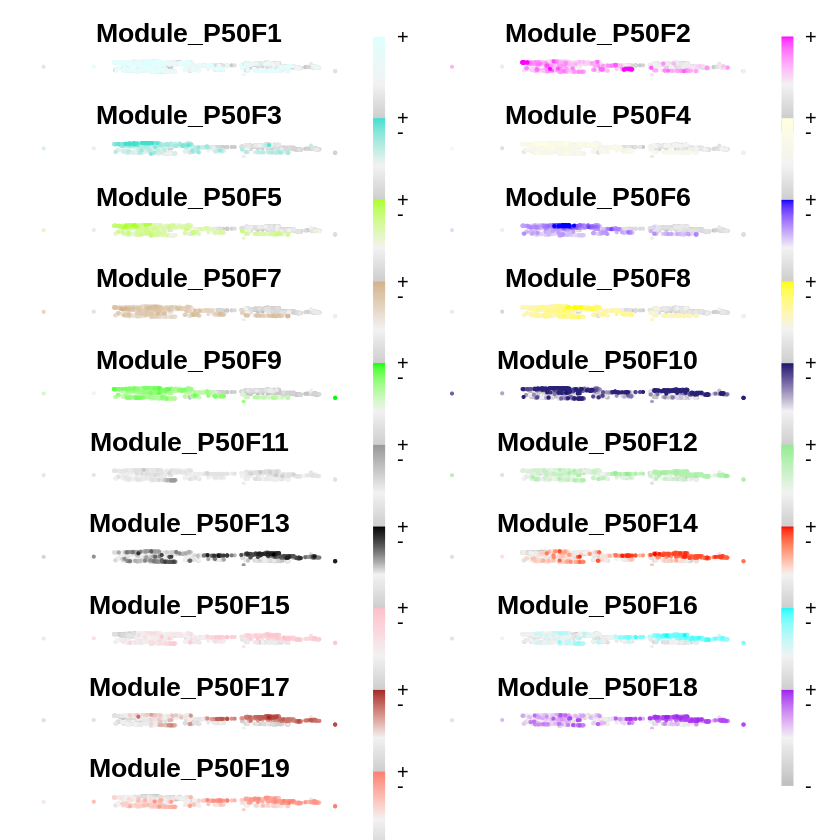

In [6]:
# make a featureplot of hMEs for each module
plot_list <- ModuleFeaturePlot(
  seurat_obj,
  features='MEs', # plot the hMEs or MEs
  order=TRUE # order so the points with highest hMEs are on top
)

# stitch together with patchwork
wrap_plots(plot_list, ncol=2)

In [7]:
# make a featureplot of hub scores for each module
plot_list <- ModuleFeaturePlot(
  seurat_obj,
  features='scores', # plot the hub gene scores
  order='shuffle' # order so cells are shuffled
)
#wrap_plots(plot_list)

[1] "Module_P50F1"
[1] "Module_P50F2"
[1] "Module_P50F3"
[1] "Module_P50F4"
[1] "Module_P50F5"
[1] "Module_P50F6"
[1] "Module_P50F7"
[1] "Module_P50F8"
[1] "Module_P50F9"
[1] "Module_P50F10"
[1] "Module_P50F11"
[1] "Module_P50F12"
[1] "Module_P50F13"
[1] "Module_P50F14"
[1] "Module_P50F15"
[1] "Module_P50F16"
[1] "Module_P50F17"
[1] "Module_P50F18"
[1] "Module_P50F19"


Warning message in pNew > sig.level:
“longer object length is not a multiple of shorter object length”
Warning message in text.default(pos.xlabel[, 1], pos.xlabel[, 2], newcolnames, srt = tl.srt, :
“"harmonized" is not a graphical parameter”
Warning message in text.default(pos.ylabel[, 1], pos.ylabel[, 2], newrownames, col = tl.col, :
“"harmonized" is not a graphical parameter”
Warning message in title(title, ...):
“"harmonized" is not a graphical parameter”


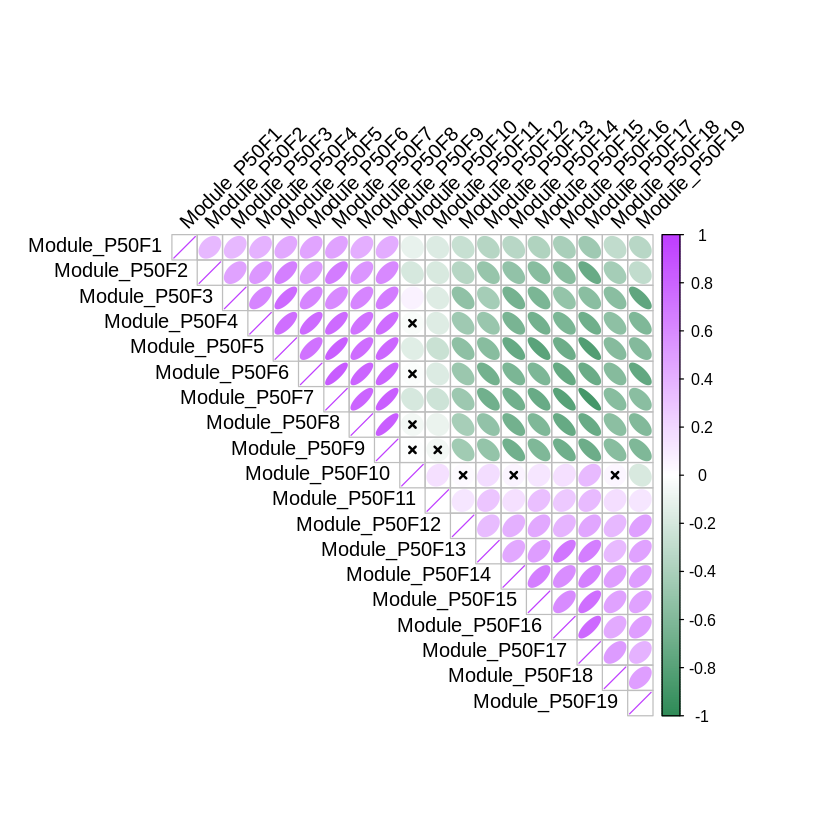

In [8]:
# plot module correlagram
ModuleCorrelogram(seurat_obj, harmonized=FALSE)

In [9]:
# add hMEs to Seurat meta-data:
seurat_obj@meta.data <- cbind(
  seurat_obj@meta.data,
  GetMEs(seurat_obj, harmonized=FALSE) # TRUE if you have multiple groups
)

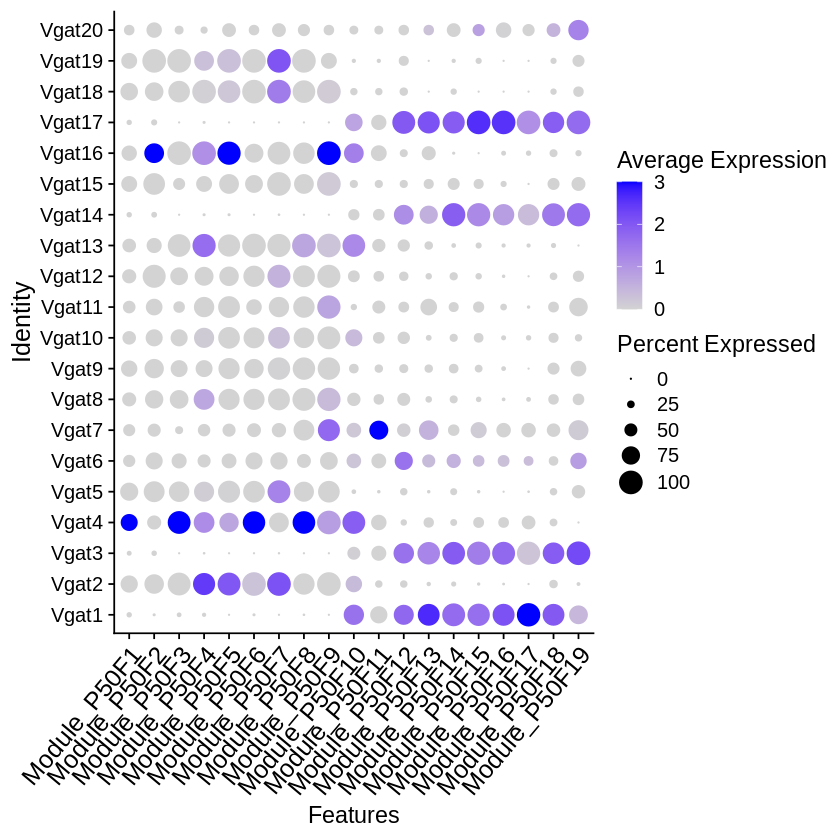

In [10]:
# modules to plot:
selected_mods <- paste0('Module_P50F', c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19))

# plot with Seurat's DotPlot function
p <- DotPlot(
    seurat_obj,
    features = selected_mods,
    group.by = 'celltype',
  col.min = 0,col.max = 3
)


# plot output
p+theme(axis.title.y=element_text(size=15),axis.text.y=element_text(size=12,colour="black"),axis.text.x=element_text(size=15,angle = 50, hjust = 1,colour="black"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black",size=0.5))#+ylab("diversity_index")
ggsave(file="/media/garret/New Volume/paper submission/MPOA_Science/Revision_Figures/raw/Module expression per clusterF_rev#2com#3.pdf",width=10,height=10)

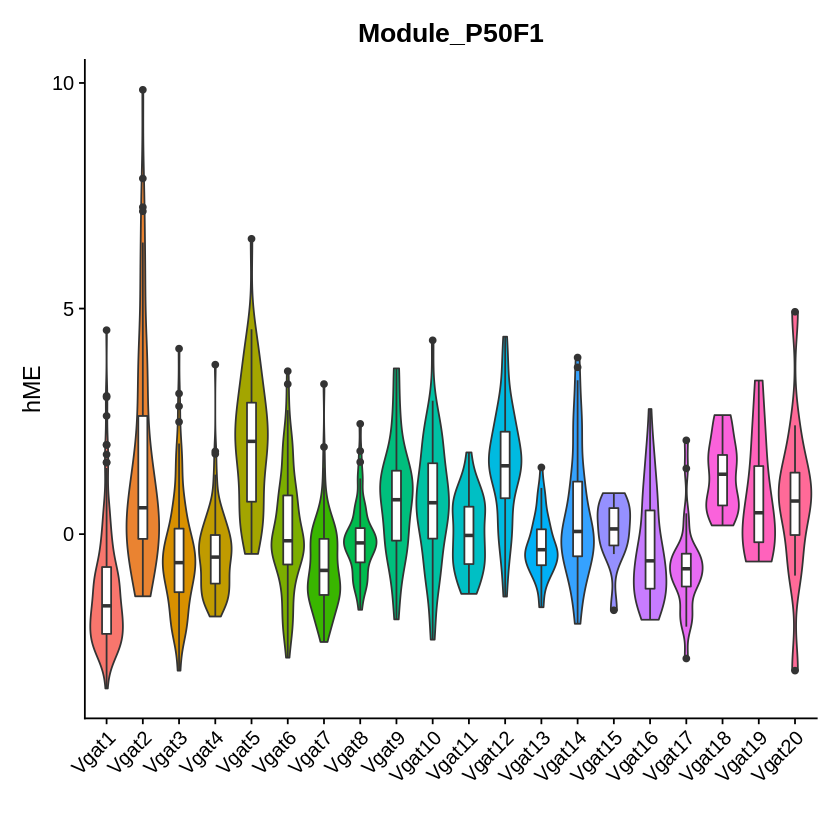

In [91]:
# Plot INH-M4 hME using Seurat VlnPlot function
p <- VlnPlot(
  seurat_obj,
  features = "Module_P50F1",
  group.by = 'celltype',
  pt.size = 0 # don't show actual data points
)

# add box-and-whisker plots on top:
p <- p + geom_boxplot(width=.25, fill='white')

# change axis labels and remove legend:
p <- p + xlab('') + ylab('hME') + NoLegend()

# plot output
p

# indivisual module network plot

In [77]:
for(i in 1:dim(seurat_obj@misc$tutorial$wgcna_modules)[1]){
    if(seurat_obj@misc$tutorial$wgcna_modules$module[i] %in% c("Module_P50F1","Module_P50F2","Module_P50F7","Module_P50F9")){
        seurat_obj@misc$tutorial$wgcna_modules$color[i]<-"salmon"
    }
}

In [78]:
ModuleNetworkPlot(seurat_obj,  outdir = "NetworkF")

Selecting by kME_Module_P50F1
Selecting by kME_Module_P50F2
Selecting by kME_Module_P50F3
Selecting by kME_Module_P50F4
Selecting by kME_Module_P50F5
Selecting by kME_Module_P50F6
Selecting by kME_Module_P50F7
Selecting by kME_Module_P50F8
Selecting by kME_Module_P50F9
Selecting by kME_Module_P50F10
Selecting by kME_Module_P50F11
Selecting by kME_Module_P50F12
Selecting by kME_Module_P50F13
Selecting by kME_Module_P50F14
Selecting by kME_Module_P50F15
Selecting by kME_Module_P50F16
Selecting by kME_Module_P50F17
Selecting by kME_Module_P50F18
Selecting by kME_Module_P50F19


[1] "here"
[1] "Module_P50F1"
 [1] "Hnrnpab"       "Dmac2"         "Cd3eap"        "Upf1"         
 [5] "Taf11"         "Parvb"         "Mrpl9"         "Chm"          
 [9] "Fbxl19"        "Hecw2"         "Ehd1"          "Sar1b"        
[13] "Sipa1l3"       "Lss"           "Larp1b"        "Ppp1r16b"     
[17] "Rrp12"         "Ccdc181"       "A530017D24Rik" "Pla2g6"       
[21] "Gm26710"       "Kcnj11"        "Extl1"         "Aspa"         
[25] "Bcl3"         
[1] "here"
[1] 25 25
[1] 25
[1] "Module_P50F2"
 [1] "Marcks"   "Cox4i1"   "Prkacb"   "Ndufb5"   "Phyhip"   "Auts2"   
 [7] "Mea1"     "Ccdc85a"  "Eri3"     "Ublcp1"   "Ddhd1"    "Rftn1"   
[13] "Rprm"     "Pip4k2a"  "Cacng4"   "Lmo1"     "Plcl1"    "Slc1a2"  
[19] "Necab2"   "Phlda1"   "Spon1"    "Tmem160"  "Serpini1" "Kcnd2"   
[25] "Gnb4"    
[1] "here"
[1] 25 25
[1] 25
[1] "Module_P50F3"
 [1] "6330403K07Rik" "Tmsb4x"        "Rpl36a"        "G3bp2"        
 [5] "Tmem130"       "Arhgef9"       "Pnmal1"        "Aes"          
 [9

Selecting by kME_VgatEsr1
Selecting by kME_VgatEsr2
Selecting by kME_VgatEsr3
Selecting by kME_VgatEsr4
Selecting by kME_VgatEsr5
Selecting by kME_VgatEsr6
Selecting by kME_VgatEsr7



VgatEsr1     grey VgatEsr2 VgatEsr3 VgatEsr4 VgatEsr5 VgatEsr6 VgatEsr7 
       8        5        8        8        8        8        8        8 
[1] "brown"     "grey90"    "green"     "yellow"    "turquoise" "blue"     
[7] "red"      
[1] "here"
[1] 485   4


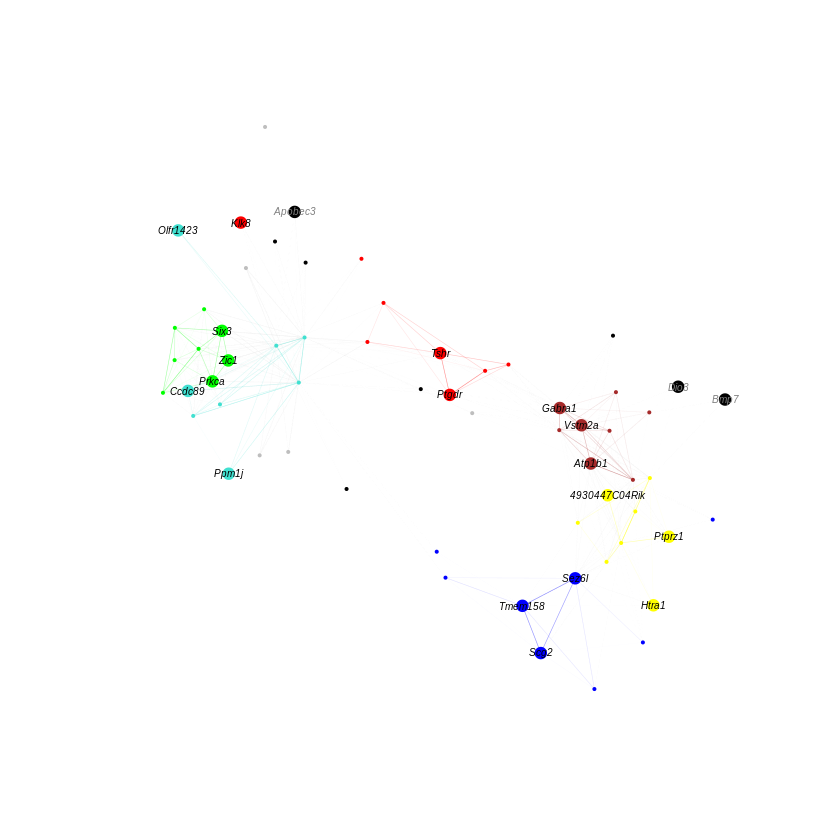

In [145]:
# hubgene network
HubGeneNetworkPlot(
  seurat_obj,
  n_hubs = 3, n_other=5,
  edge_prop = 0.75,
  mods = 'all'
)

# ontology analysis

In [10]:
# enrichr databases to test
dbs <- c('GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021')



In [11]:
# perform enrichment tests
seurat_obj <- RunEnrichr(
  seurat_obj,
  dbs=dbs, # character vector of enrichr databases to test
  max_genes = 100 # number of genes per module to test
)


Selecting by kME_Module_P50F1


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F2


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F3


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F4


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F5


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F6


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F7


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F8


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F9


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F10


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F11


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F12


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F13


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F14


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F15


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F16


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F17


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F18


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


Selecting by kME_Module_P50F19


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
  Querying GO_Cellular_Component_2021... Done.
  Querying GO_Molecular_Function_2021... Done.
Parsing results... Done.


In [12]:

# retrieve the output table
enrich_df <- GetEnrichrTable(seurat_obj)

In [13]:
# make GO term plots:
EnrichrBarPlot(
  seurat_obj,
  outdir = "enrichr_plotsF", # name of output directory
  n_terms = 10, # number of enriched terms to show (sometimes more show if there are ties!!!)
  plot_size = c(5,7), # width, height of the output .pdfs
  logscale=TRUE # do you want to show the enrichment as a log scale?
)

[1] "Module_P50F1"
[1] "Module_P50F2"
[1] "Module_P50F3"
[1] "Module_P50F4"
[1] "Module_P50F5"
[1] "Module_P50F6"
[1] "Module_P50F7"
[1] "Module_P50F8"
[1] "Module_P50F9"
[1] "Module_P50F10"
[1] "Module_P50F11"
[1] "Module_P50F12"
[1] "Module_P50F13"
[1] "Module_P50F14"
[1] "Module_P50F15"
[1] "Module_P50F16"
[1] "Module_P50F17"
[1] "Module_P50F18"
[1] "Module_P50F19"


Warning message in if (mods == "all") {:
“the condition has length > 1 and only the first element will be used”


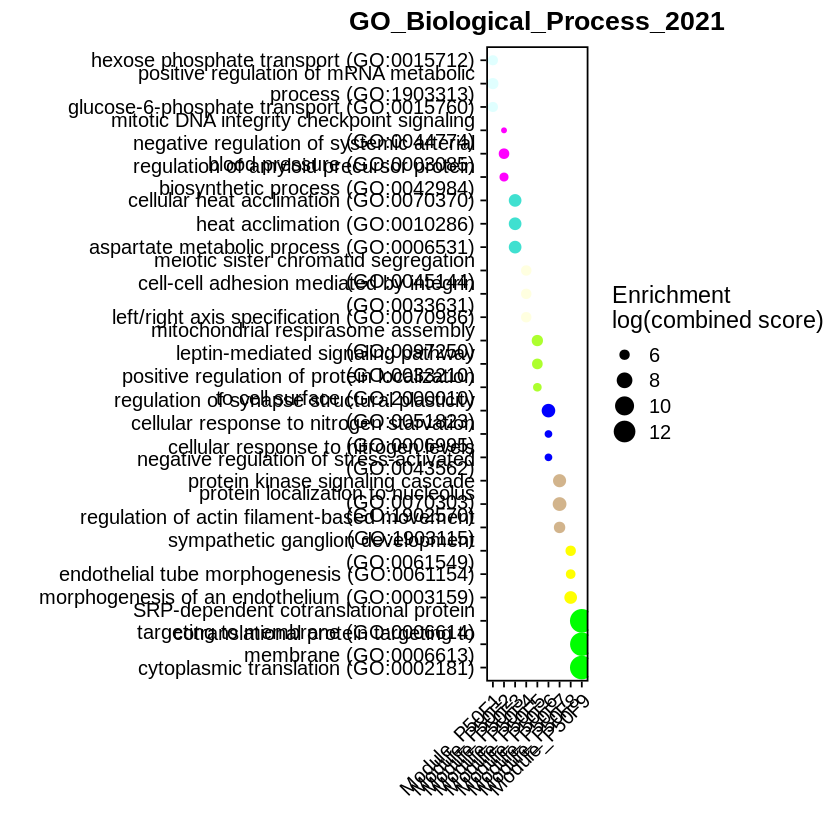

In [159]:
# enrichr dotplot
# modules to plot:
selected_mods <- paste0('Module_P50F', c(1,2,3,4,5,6,7,8,9))

EnrichrDotPlot(
  seurat_obj,
  mods = selected_mods, # or "all"# use all modules (this is the default behavior)
  database = "GO_Biological_Process_2021", # this has to be one of the lists we used above!!!
  n_terms=3 # number of terms for each module
)
ggsave(file="/media/garret/New Volume/paper submission/MPOA_Science/Revision_Figures/raw/Esr1_Module Ontology_term_GO_Biological_Process_2021_F_rev#2com#3.pdf",width=8,height=10)

Warning message in if (mods == "all") {:
“the condition has length > 1 and only the first element will be used”


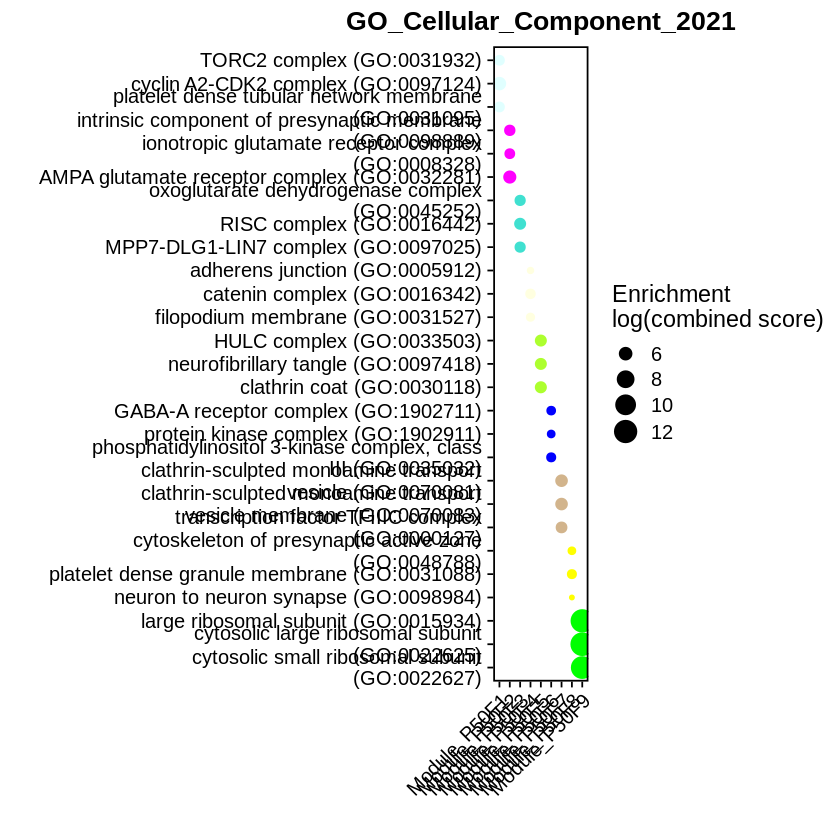

In [160]:
# enrichr dotplot
selected_mods <- paste0('Module_P50F', c(1,2,3,4,5,6,7,8,9))

EnrichrDotPlot(
  seurat_obj,
  mods = selected_mods, # or "all"# use all modules (this is the default behavior)
  database = "GO_Cellular_Component_2021", # this has to be one of the lists we used above!!!
  n_terms=3 # number of terms for each module
)
ggsave(file="/media/garret/New Volume/paper submission/MPOA_Science/Revision_Figures/raw/Esr1_Module Ontology_term_GO_Cellular_Component_2021_F_rev#2com#3.pdf",width=8,height=10)

Warning message in if (mods == "all") {:
“the condition has length > 1 and only the first element will be used”


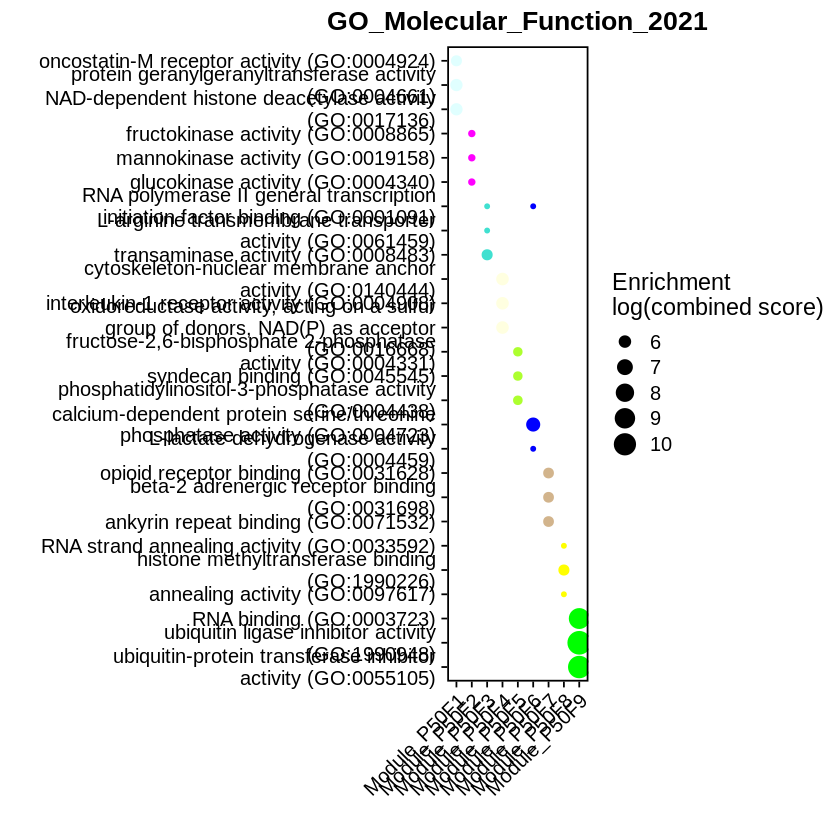

In [15]:
# enrichr dotplot
selected_mods <- paste0('Module_P50F', c(1,2,3,4,5,6,7,8,9))

EnrichrDotPlot(
  seurat_obj,
  mods = selected_mods, # or "all"# use all modules (this is the default behavior)
  database = "GO_Molecular_Function_2021", # this has to be one of the lists we used above!!!
  n_terms=3 # number of terms for each module
)
ggsave(file="/media/garret/New Volume/paper submission/MPOA_Science/Revision_Figures/raw/Esr1_Module Ontology_term_GO_Molecular_Function_2021_F_rev#2com#3.pdf",width=8,height=10)

# jaccard similarity of modules between sexes

In [28]:
seurat_objF<-readRDS(file='scWGCNA_object_ownMPOAF_4000_10_VgatEsr1.rds')
seurat_objM<-readRDS(file='scWGCNA_object_ownMPOAM_4000_25_VgatEsr1.rds')

In [79]:
Male<-paste0('Module_P50M', c(1,2,3,4,5,6))
Female<-paste0('Module_P50F', c(9,3,8,6,5,2,4,1,7))

In [80]:
corr<- data.frame(matrix(NA, ncol=length(Male),nrow=length(Female)))
rownames(corr)<-factor(Female,levels=Female)
colnames(corr)<-factor(Male,levels=Male)

for (i in 1:length(Male)){
    for (j in 1:length(Female)){
    temp1<-subset(seurat_objM@misc$tutorial$ wgcna_modules,module==Male[i])$gene_name
    temp2<-subset(seurat_objF@misc$tutorial$ wgcna_modules,module==Female[j])$gene_name
        corr[j,i]<-length(intersect(temp1,temp2))/(length(temp1)+length(temp2)-length(intersect(temp1,temp2)))
}}

test.m <- melt(as.matrix(corr))

test.m$Var1<-factor(test.m$Var1,levels=rev(Female))

In [81]:
max(corr)

[1] 0.2150838

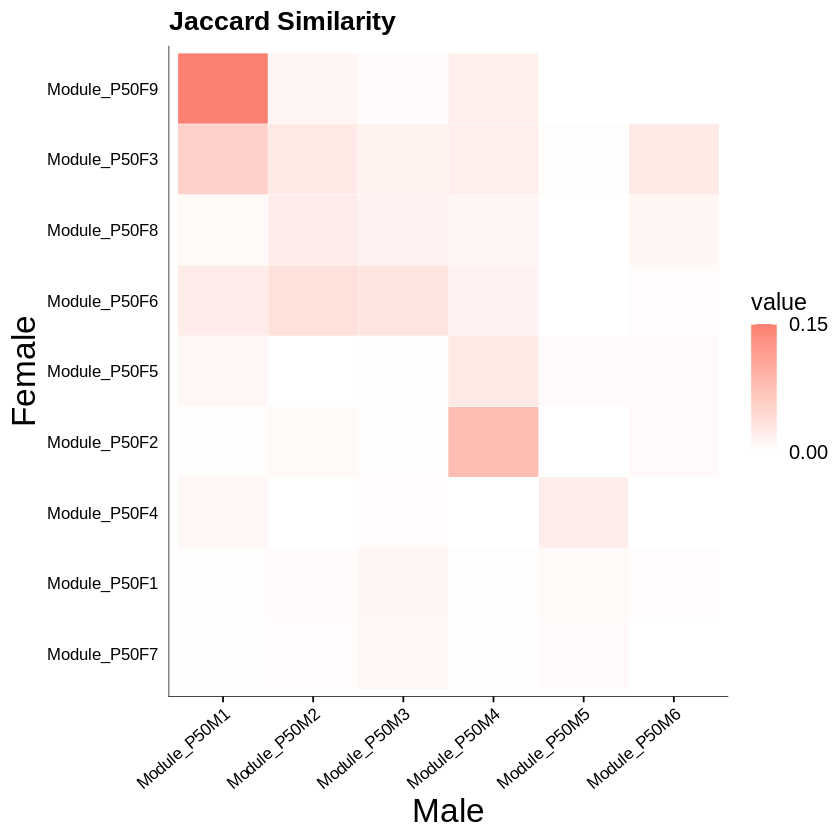

In [84]:
p <- ggplot(test.m, aes(Var2, Var1)) + geom_tile(aes(fill =value),
     colour = "white")+ scale_fill_continuous(limits=c(0, 0.15), breaks=seq(0,0.15,by=0.15),low = "white",high = "salmon", oob=squish)
#scale_x_discrete(breaks=c(0,5994,7712,9820,11428,11674,11836,11878))
pp<-p+ylab("Female")+xlab("Male")+theme(axis.text.x=element_text(size=10,color="black",angle=40,h=1),axis.text.y=element_text(size=10,color="black"),axis.title=element_text(size=20,color="black"),plot.title = element_text(size=16,color="black"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black", size = 0.2),axis.ticks.y = element_blank())+ggtitle("Jaccard Similarity")
print(pp)
ggsave(file="/media/garret/New Volume/paper submission/MPOA_Science/Revision_Figures/raw/Esr1_Module Jaccard_YF_XM_rev#2com#3.pdf",width=8,height=6)